- title: An Approach to Computing Predicted Purchase - Part 3
- date: 2020-04-02 12:00
- category: tutorial
- tags: marketing, python, sales
- slug: predict_sales_3
- authors: Julien Hernandez Lallement
- summary: How parameter distribution influences BetaGeo model fit
- illustration: header_sales_prediction_other.jpg

## **Background:** <br>
This post is part of a series on the topic of purchase prediction [here](https://juls-dotcom.github.io/predict_sales_2.html) and [here](https://juls-dotcom.github.io/predict_sales_3.html). <br>
If you have not read it yet, I suggest you get a quick read of the initial post before going on.

In this post, I want to explore the concepts of model assumptions. <br><br>
If you work with frequentists statistics, you probably remember all these assumptions inherent to running some tests right? Easiest one is probably the assumptions inherent to running parametric statistical testing (*homogeneity of variances, normal distributions, high enough sample size*). <br><br>
However, many models come up with their set of assumptions which are often overlooked when fitting the model. <br><br>
Being relatively new to the field of customer valuation, I wanted to explore how important the assumptions of the BetaGeo model were. <br><br>

## **Assumption Testing** <br>

Let's refresh one particular assumption of this model:

Heterogeneity in transaction rate lambda follows a gamma distribution: (Fader et al. 2005)

\begin{equation*}
\left( \ f(\lambda | r, \alpha \right) = \left( \ \frac{\alpha^r \lambda^{r-1} e^{-\lambda \alpha}}{\Gamma r} \right)       \left(\lambda > 0\right)
\end{equation*}


As a use case, I decided to play a bit with the shape of the data to see how that affected the model's fit.

Import necessary libraries

In [148]:
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import plotnine as p9
import scipy.stats
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

display_settings = {
    'max_columns': 10,
    'expand_frame_repr': True,  # Wrap to multiple pages
    'max_rows': 50,
    'precision': 2,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)

from IPython.display import clear_output
import timeit

# Set figure size for easier reading
plt.rcParams['figure.figsize'] = (16,8)

First of all, what is a gamma ditribution? <br> <br>
The numpy library provides nice built-in functions to draw from many distriutions, including the gamma. <br><br>
Let's plot a few of these by changing the parameters:

Scale gamma distribution:0.5
p-val shapiro: 5.1502623108562164e-40
p-val skewness: 8.969301717541406e-100

Scale gamma distribution:0.8
p-val shapiro: 3.6884475773222017e-34
p-val skewness: 3.9443995903059814e-73

Scale gamma distribution:1.0
p-val shapiro: 5.9433405800597644e-33
p-val skewness: 3.3306899312628774e-72

Scale gamma distribution:2.0
p-val shapiro: 1.848402075128699e-24
p-val skewness: 5.112733258155591e-43

Scale gamma distribution:3.0
p-val shapiro: 7.752681790258775e-20
p-val skewness: 2.96358455129364e-28

Scale gamma distribution:20.0
p-val shapiro: 4.688251920015318e-08
p-val skewness: 1.048116569048816e-09



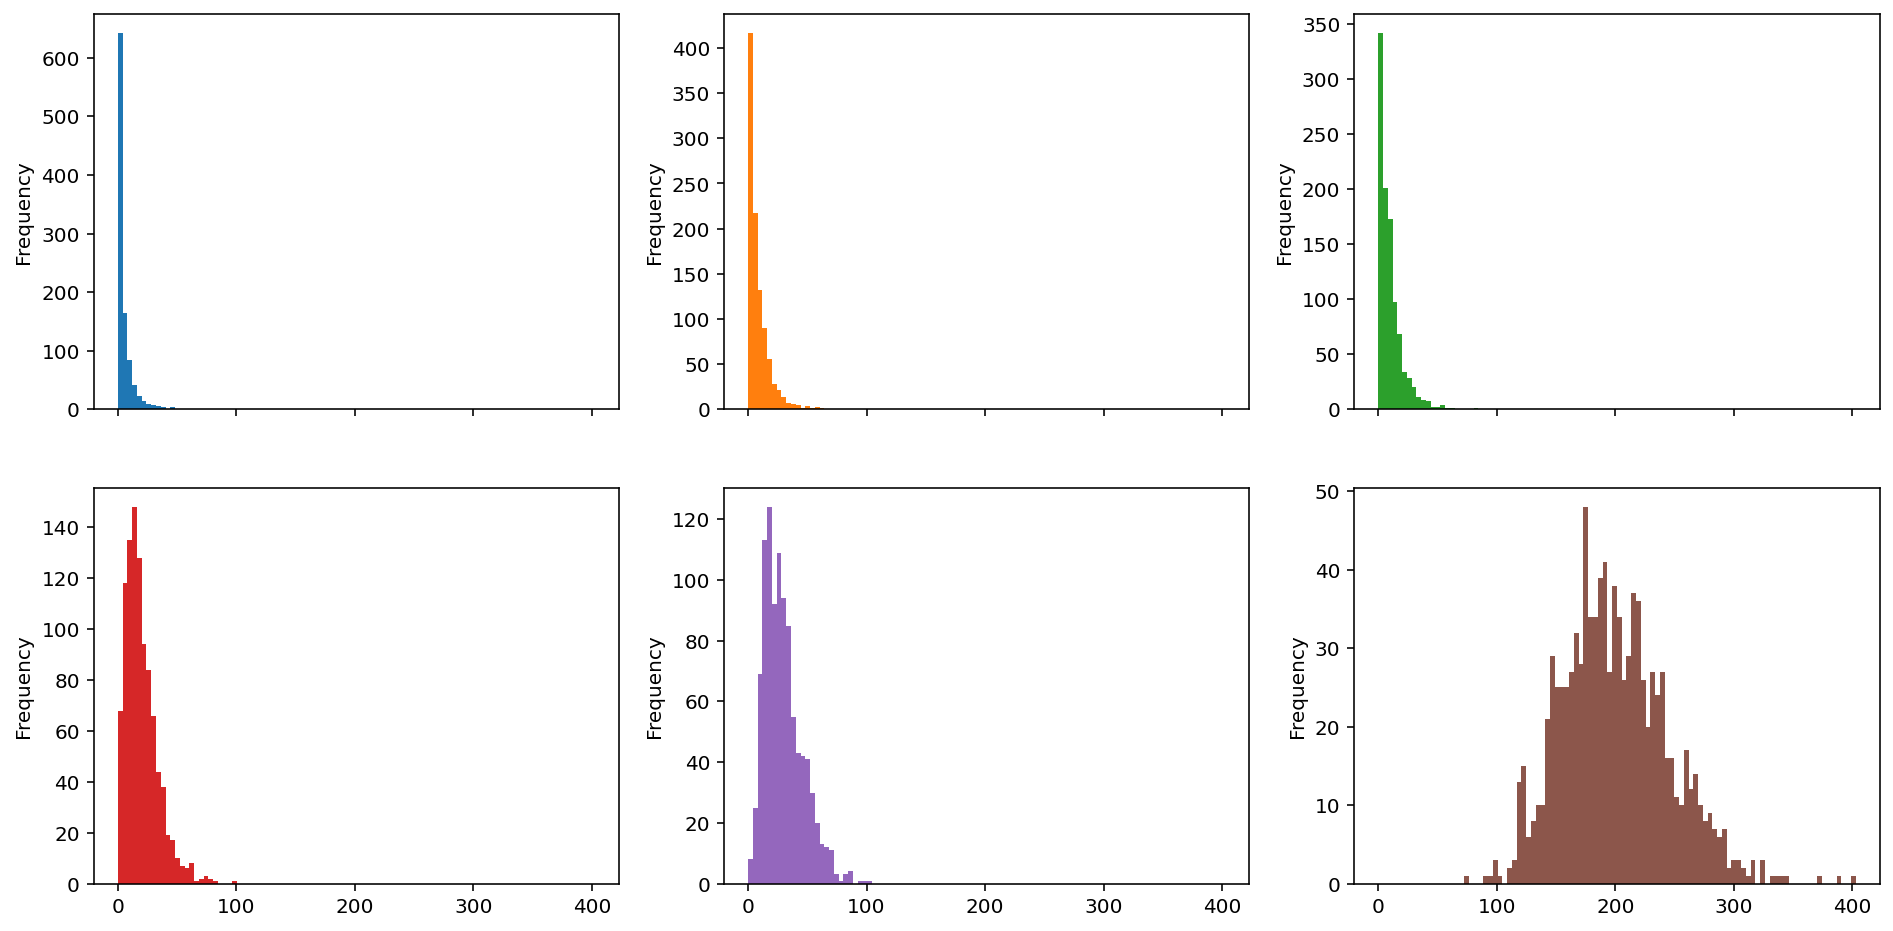

In [149]:
scale = [0.5,0.8,1.0,2.0,3.0, 20.0]
gamma_examples = pd.DataFrame()

for row in range(0,len(scale)):
    # Create different gamma distributions with the scale values
    gamma_examples = gamma_examples.append(pd.Series(np.random.gamma(size = 1000,
                                                                     scale = 10,
                                                                     shape = scale[row])
                                          ),ignore_index=True)
    print('Scale gamma distribution:' + str(scale[row]))
    print('p-val shapiro: ' + str(scipy.stats.shapiro(gamma_examples.iloc[row, :])[1]))
    print('p-val skewness: ' + str(scipy.stats.skewtest(gamma_examples.iloc[row, :], axis=0)[1]))
    print("")
gamma_examples.T.plot(kind='hist',
                      bins=100, 
                      subplots=True, 
                      layout=(2,3),
                      legend=False
                     );



We can see that the distribution becomes decreasingly skewed, althouth still follows a gaussian, with increasing scale values. <br>
The transaction rate assumed as gamma distributed seems now quite reasonable, since most customers woudl typically have low purchase number (rather bad customers), while a small subset would purchase often from your business. <br><br>
One thing to note is that, while gamma distributions are normally distributed (significant Shapiro test), they are extremely skewed for low scale values, and seem rather gaussian for high scale values. <br><br>

How might that affect the model fit?

## **Data Generation**

In the previous post, we showed that the BetaGeo model was quite accurate in predicting future purchase of customers in a real world dataset

Now let's see if we can reproduce the results with simulated data, which will then allow us to change some feature distribution and see how that affects the fit of the model. <br> <br>
As we saw, typical transactional data will provide features such as transaction date, quantity purchased, generated turnover (sometimes with other monetary KPIs such as margin or order value), and of course a customer ID so that transactions can be brought down to the customer level <br>

Let's say we want gathered data from a number of customers = nCustomers, who performed transactions between 01.01.2018 & 01.01.2020. <br>
Let's further assume that a subset of these customers would have purchased only one time, while others would have performed repeated purchases (let's say 50/50)                                                                                                     

In [218]:
# Total number of customers in our simulated dataset
nCustomers = 500000

# Proportion rebuyers
proportion_rebuyers = 0.5

# Start of the transaction period
start_observation_period = '2018-01-01'

# End of the transaction period
end_observation_period   = '2020-01-01'

# Seed NumPy random generator for reproduction purposes
np.random.seed(42)# 

# DataFrame to fill with simulated transactional data
df_transactions = pd.DataFrame()

Create customer IDs

In [219]:
import random
import string

def generate_customer_random_id(length=10, units = nCustomers, chars=string.ascii_uppercase + string.digits):
    return ["".join([random.choice(chars) for i in range(length)]) for j in range(units)]


df_transactions = (df_transactions
                    .assign(customer_id = generate_customer_random_id(length = 10, 
                                                                      units  = nCustomers
                                                                     )
                            )
)

Now let's create a transaction rate based on one gamma distribution. <br>
We will then explore how varying this distribution's parameter affects the model fit.

In [221]:
gamma_shape = 0.5
# Keep the scale constant for simplicity
gamma_scale = 4

# Create logical mask for rebuyers and one time buyers
mask_rebuyers        = np.ones (int(nCustomers*   proportion_rebuyers))
mask_one_time_buyers = np.zeros(int(nCustomers*(1-proportion_rebuyers)))

# Create mask from distribution to create purchaser customers 
purchaser_distribution_gamma = np.random.gamma(shape = gamma_shape,
                                               scale = gamma_scale,
                                               size=int(nCustomers*proportion_rebuyers)
                                        ).round()

# purchaser_distribution_unifo = np.random.uniform(low = 1, 
#                                            high = max_purchase_number, 
#                                            size = int(nCustomers*proportion_rebuyers)
#                                           )
# Add random purchases for some of the rebuyers customers
mask_rebuyers = (mask_rebuyers + purchaser_distribution_gamma)

# Set one time buyers purchase number = 1
mask_one_time_buyers = mask_one_time_buyers + 1

# Concatenate masks
purchase_mask = np.concatenate([mask_rebuyers,
                                mask_one_time_buyers])

# Shuffle mask
np.random.shuffle(purchase_mask)

# Assign the number of purchases as column
df_transactions = df_transactions.assign(number_of_purchases = purchase_mask.astype(int))
# Repeat entries for customers that bought more than once
df_transactions = df_transactions.loc[df_transactions.index.repeat(df_transactions.number_of_purchases)]
# Shuffle the data
from sklearn.utils import shuffle
df_transactions = shuffle(df_transactions)

In [222]:
df_transactions

,customer_id,number_of_purchases
458371,IIMEIAPGIN,6
55792,TBXWZHARCW,2
31301,TAXUQ9N6MJ,1
124653,QA4ZP3PBBJ,1
483273,QLLHPRVWNO,5
...,...,...
192548,JCVA2AS4FQ,3
481496,L8HB2KG3QR,28
105591,TL92VVEJ9K,3
288710,KY2SWON5F1,17


In a third step, I generate random dates

In [249]:
def generate_random_dates(start, end, n):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n, dtype=np.int64)))

In [250]:
# Generate random dates
random_dates = generate_random_dates(start = pd.to_datetime(start_observation_period),
                                     end = pd.to_datetime(end_observation_period), 
                                     #n = np.floor((df_transactions.shape[0]/1000)).astype(int))
                                     n = (df_transactions.shape[0]))
                                      

df_transactions = df_transactions.assign(receipt_date = np.random.choice(random_dates, 
                                                                         size=df_transactions.shape[0],
                                                                         replace=True))
                                            

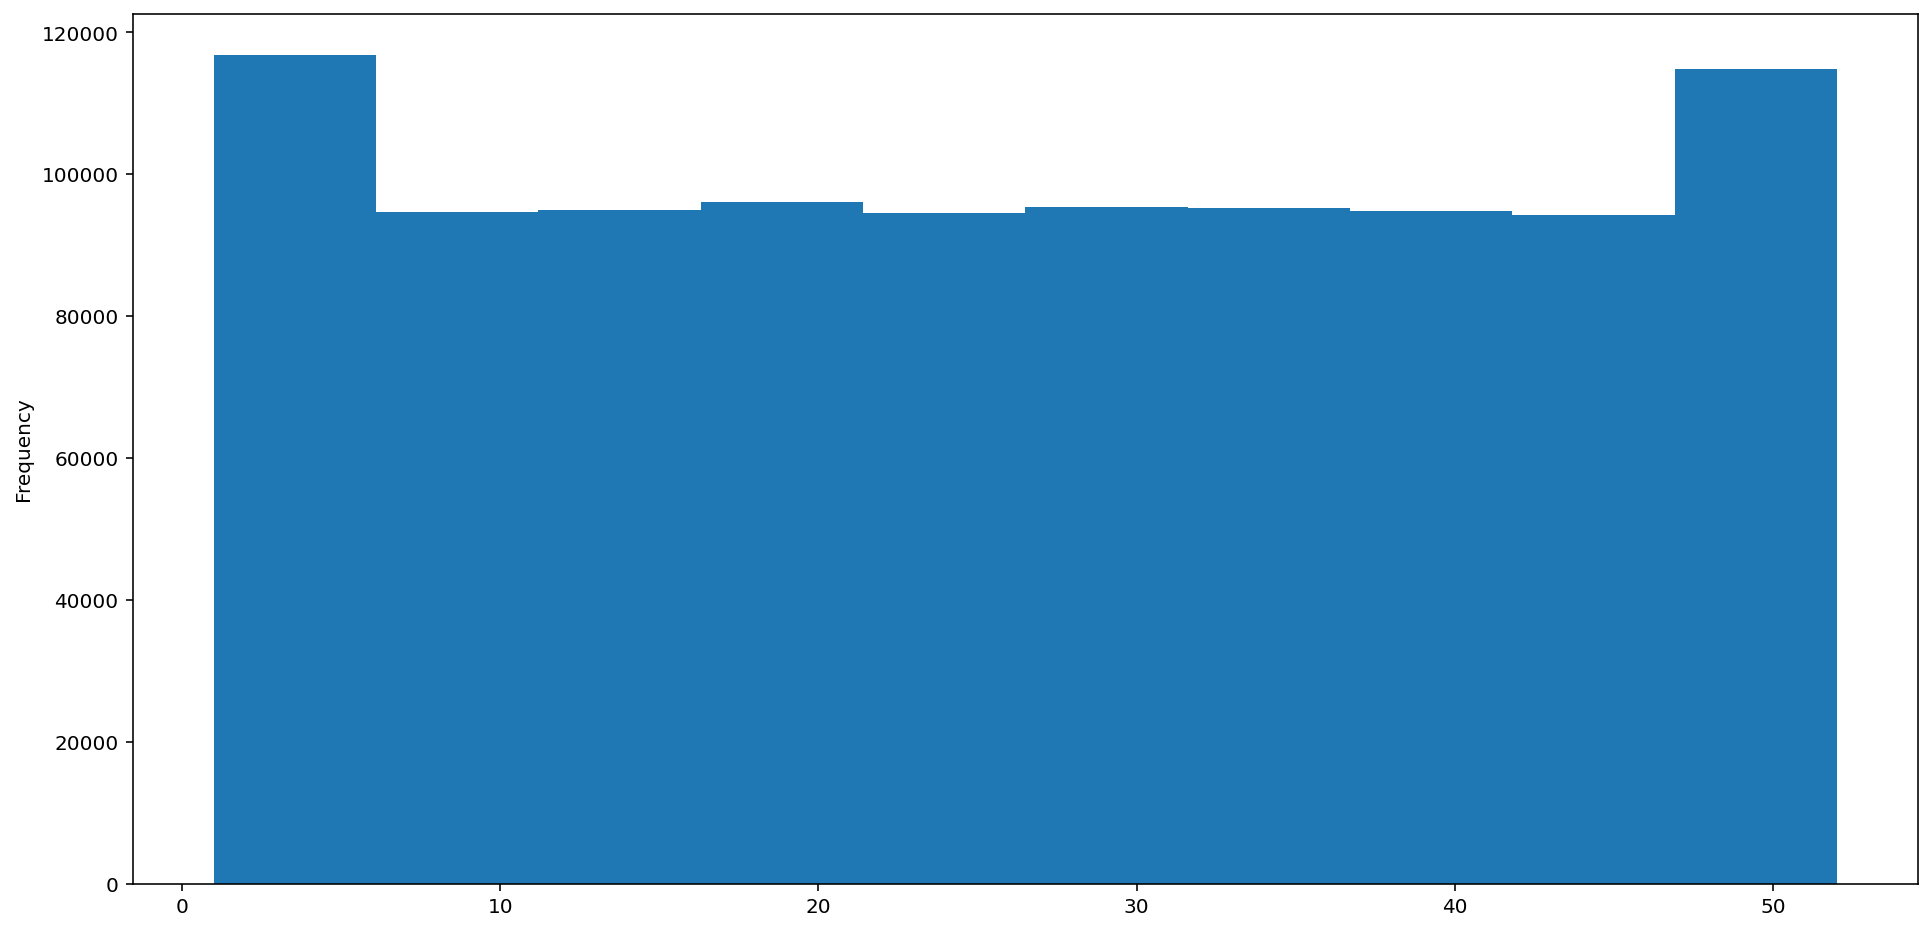

In [271]:
df_transactions.receipt_date.dt.week.plot(kind='hist')

Finally, let's add some monetary data, such as the turnover generated by receipt. <br>
Here, I assume that the data has been corrected for retours, but that should of course be checked before hand

In [251]:
df_transactions = df_transactions.assign(monetary_value = np.random.gamma(shape=10, size=df_transactions.shape[0])) 
                                         #np.random.rand(df_transactions.shape[0])*100)

In [252]:
df_transactions.sample(20)

,customer_id,number_of_purchases,receipt_date,monetary_value
124425,IBVQL6YN8V,10,2019-11-14 23:34:55,6.81
427868,77VCC70W2H,12,2018-05-16 20:24:06,10.47
196959,ZSKDGRMYTD,4,2018-01-13 16:40:17,9.02
455213,KQTZR6NRNG,4,2019-04-15 15:39:41,13.23
74569,16CQ9O28EE,5,2019-03-26 01:51:42,8.95
147530,FARRQIPMD0,1,2018-11-29 12:14:01,8.79
337394,BAC1BEZ09O,1,2018-11-12 16:32:24,8.29
383576,V4JVC81ZTT,2,2019-01-04 00:14:28,11.33
389489,MYJAQ6UWD9,5,2018-08-01 22:23:28,10.62
403344,QLK1XG2F6A,1,2019-05-31 11:07:40,10.44


Good, now we have some dataset, generated randomly (pseudo-random actually, since we seeded the random generator) on which we can work on, to predict purchases at the customer level.

We are going to need a few data features currently contained, but not isolated in the dataset. <br>
As seen in the previous post, we need the age of the customer (birth being the first purchase, as well as some data about recency (last purchase). We already have the frequency. <br>

Below a few functions that will compute these features and put them together into a new dataframe

In [253]:
# Munging pipeline
# Start munging pipeline by copying the dataframe
def start_pipeline(dataf):
    dataf = dataf.copy()
    return dataf

# Format columns
def format_cols(dataf):
    dataf.columns = [c.lower() for c in dataf.columns]
    dataf.columns = [c.replace(' ', '_') for c in dataf.columns]
    return dataf

def correct_timestamps(dataf):
    return (dataf
     .assign(receipt_date = pd.to_datetime(dataf['receipt_date'],format="%Y/%m/%d"))
            )

def first_last_receipt_dates(dataf):
    dataf["first_receipt_date"] = dataf.groupby('customer_id').receipt_date.transform('min')
    dataf["last_receipt_date"]  = dataf.groupby('customer_id').receipt_date.transform('max')
    return dataf

def compute_age_recency(dataf,timestamp_ref='2020-03-01T00'):
    return (dataf
    .assign(age_in_weeks     = lambda d: (pd.Timestamp(timestamp_ref)# pd.to_datetime("now") 
                                        - d['first_receipt_date']).dt.days / 7)
    .assign(recency_in_weeks = lambda d: (d['last_receipt_date'] 
                                        - d['first_receipt_date']).dt.days / 7))


In [254]:
df_ml = (df_transactions
.pipe(start_pipeline)
.pipe(format_cols)            
.pipe(correct_timestamps)
.pipe(first_last_receipt_dates)
.pipe(compute_age_recency, timestamp_ref = '2020-01-01')
)

df_ml.head(10)

,customer_id,number_of_purchases,receipt_date,monetary_value,first_receipt_date,last_receipt_date,age_in_weeks,recency_in_weeks
458371,IIMEIAPGIN,6,2019-03-29 07:59:20,8.64,2018-08-18 08:57:53,2019-09-07 21:17:35,71.43,55.00
55792,TBXWZHARCW,2,2018-09-19 04:26:19,16.09,2018-09-19 04:26:19,2019-07-29 08:17:36,66.86,44.71
31301,TAXUQ9N6MJ,1,2018-07-12 21:25:06,12.03,2018-07-12 21:25:06,2018-07-12 21:25:06,76.71,0.00
124653,QA4ZP3PBBJ,1,2019-02-20 15:02:14,6.77,2019-02-20 15:02:14,2019-02-20 15:02:14,44.86,0.00
483273,QLLHPRVWNO,5,2019-06-23 12:55:22,8.71,2018-02-24 07:02:36,2019-12-24 14:53:37,96.43,95.43
431296,AZRUWNEO3D,1,2019-06-01 08:52:13,15.72,2019-06-01 08:52:13,2019-06-01 08:52:13,30.43,0.00
27444,Y5UM05NIRS,2,2018-11-01 18:59:49,5.70,2018-01-29 20:50:05,2018-11-01 18:59:49,100.14,39.29
255476,QGJF0V29SW,2,2019-03-08 20:28:57,20.36,2019-01-23 22:01:38,2019-03-08 20:28:57,48.86,6.14
34808,VF9XY2L261,1,2018-06-16 17:28:14,13.03,2018-06-16 17:28:14,2018-06-16 17:28:14,80.43,0.00
408744,9CR9VCKGLD,6,2018-03-02 23:34:29,11.38,2018-03-01 06:15:12,2019-12-25 15:07:16,95.71,94.86


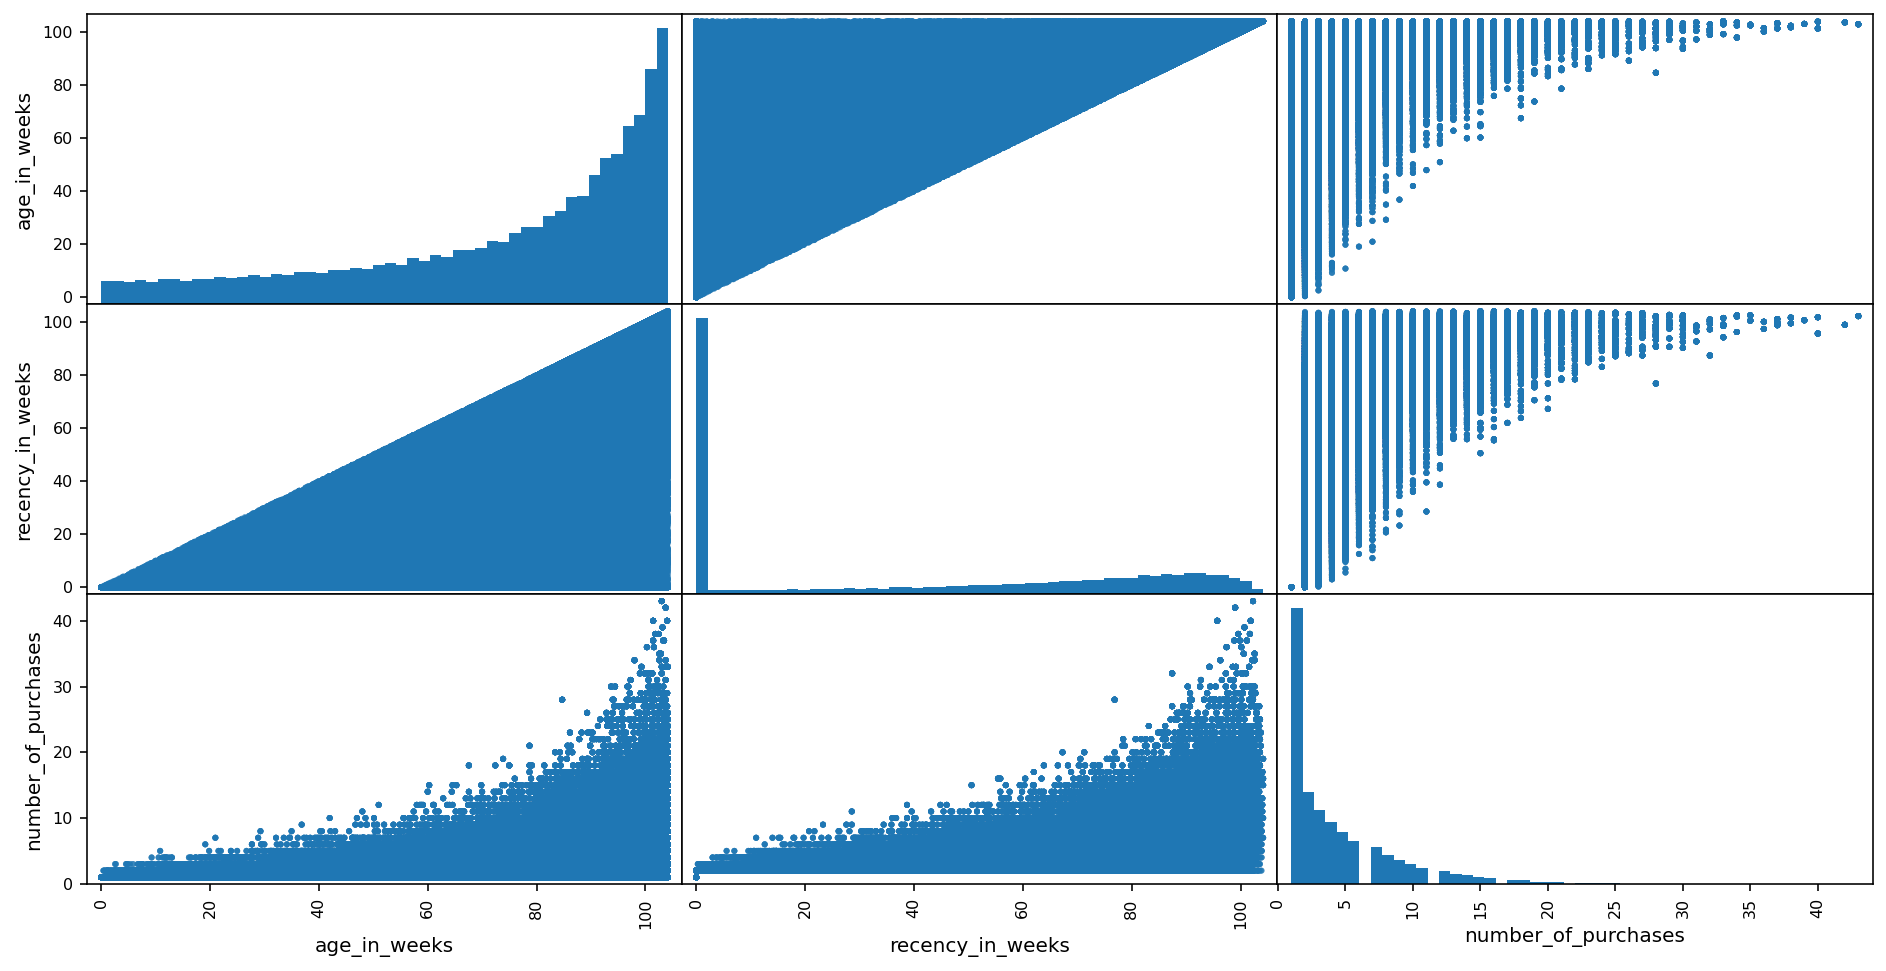

In [255]:
pd.plotting.scatter_matrix(df_ml[['age_in_weeks', 'recency_in_weeks','number_of_purchases']],hist_kwds={'bins':50});


There is obviously some issues with this simulated data, in particular with the relation between age and recency.<br>

## The Beta Geo model for predicting customer purchase

In a paper published in 2005, Fader, Hardie & Lee proposed a modified version of the typically used Pareto model, which had been quite challenging to implement from a computation perspective.

In [39]:
# Import models
from lifetimes import BetaGeoFitter,ParetoNBDFitter
bgf = BetaGeoFitter(penalizer_coef=10.)

#bgf_Pareto = ParetoNBDFitter(penalizer_coef=0.1)

In [40]:
# Verify that the model is doing a relatively good job at predicting values
from lifetimes.utils import calibration_and_holdout_data
# This function creates a summary of each customer over a calibration and holdout period (training and testing)
# It accepts transaction data, and returns a DataFrame of sufficient statistics.
summary_cal_holdout = calibration_and_holdout_data(df_ml, 'customer_id', 'receipt_date',
                                                    calibration_period_end='2019-06-01',
                                                    observation_period_end='2020-01-01',
                                                    freq='W',
                                                   # monetary_value_col = 'monetary_value'
                                                  )

/home/julien/anaconda3/envs/data_blog/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


,coef,se(coef),lower 95% bound,upper 95% bound
r,1.22e-01,2.13e-04,1.22e-01,1.23e-01
alpha,1.10e+00,5.14e-03,1.09e+00,1.11e+00
a,1.50e-19,6.87e-16,-1.35e-15,1.35e-15
b,5.51e-08,2.42e-04,-4.74e-04,4.74e-04


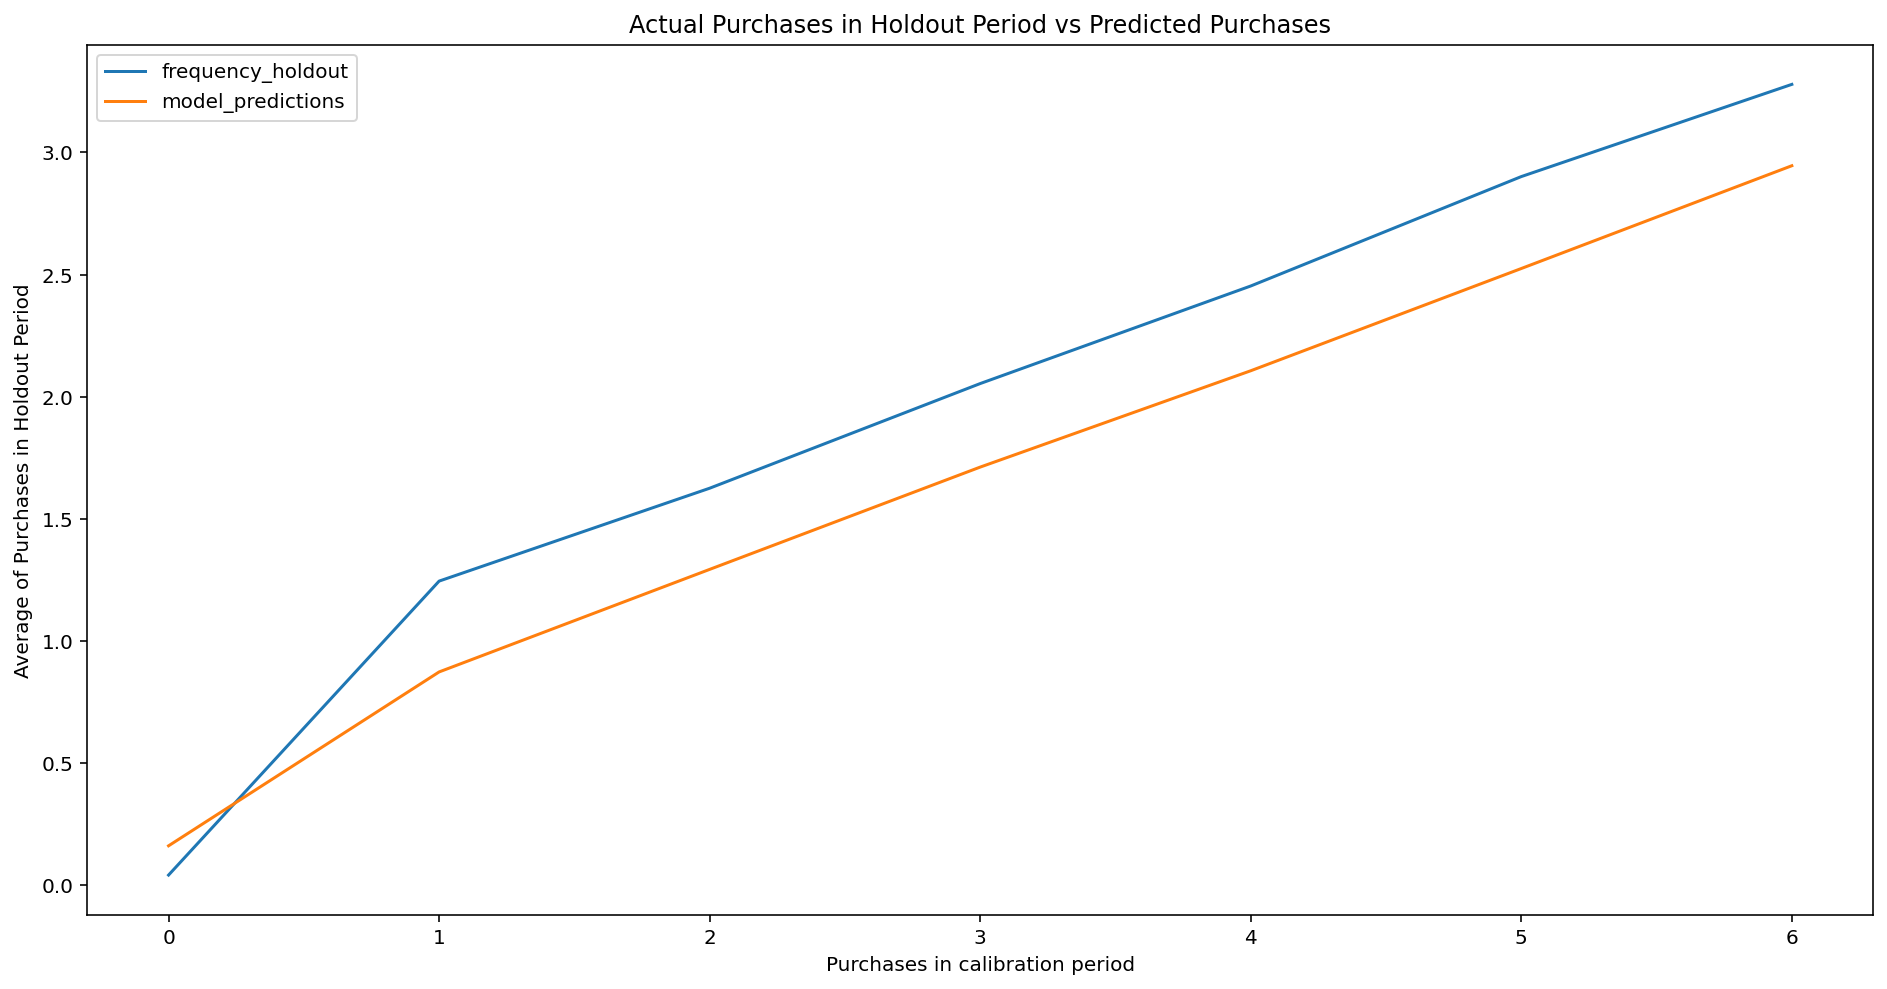

In [20]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,5.50e-02,1.88e-04,5.46e-02,5.54e-02
alpha,2.44e+00,1.62e-02,2.41e+00,2.47e+00
a,3.23e-03,2.57e-04,2.72e-03,3.73e-03
b,2.97e-03,2.34e-04,2.51e-03,3.43e-03


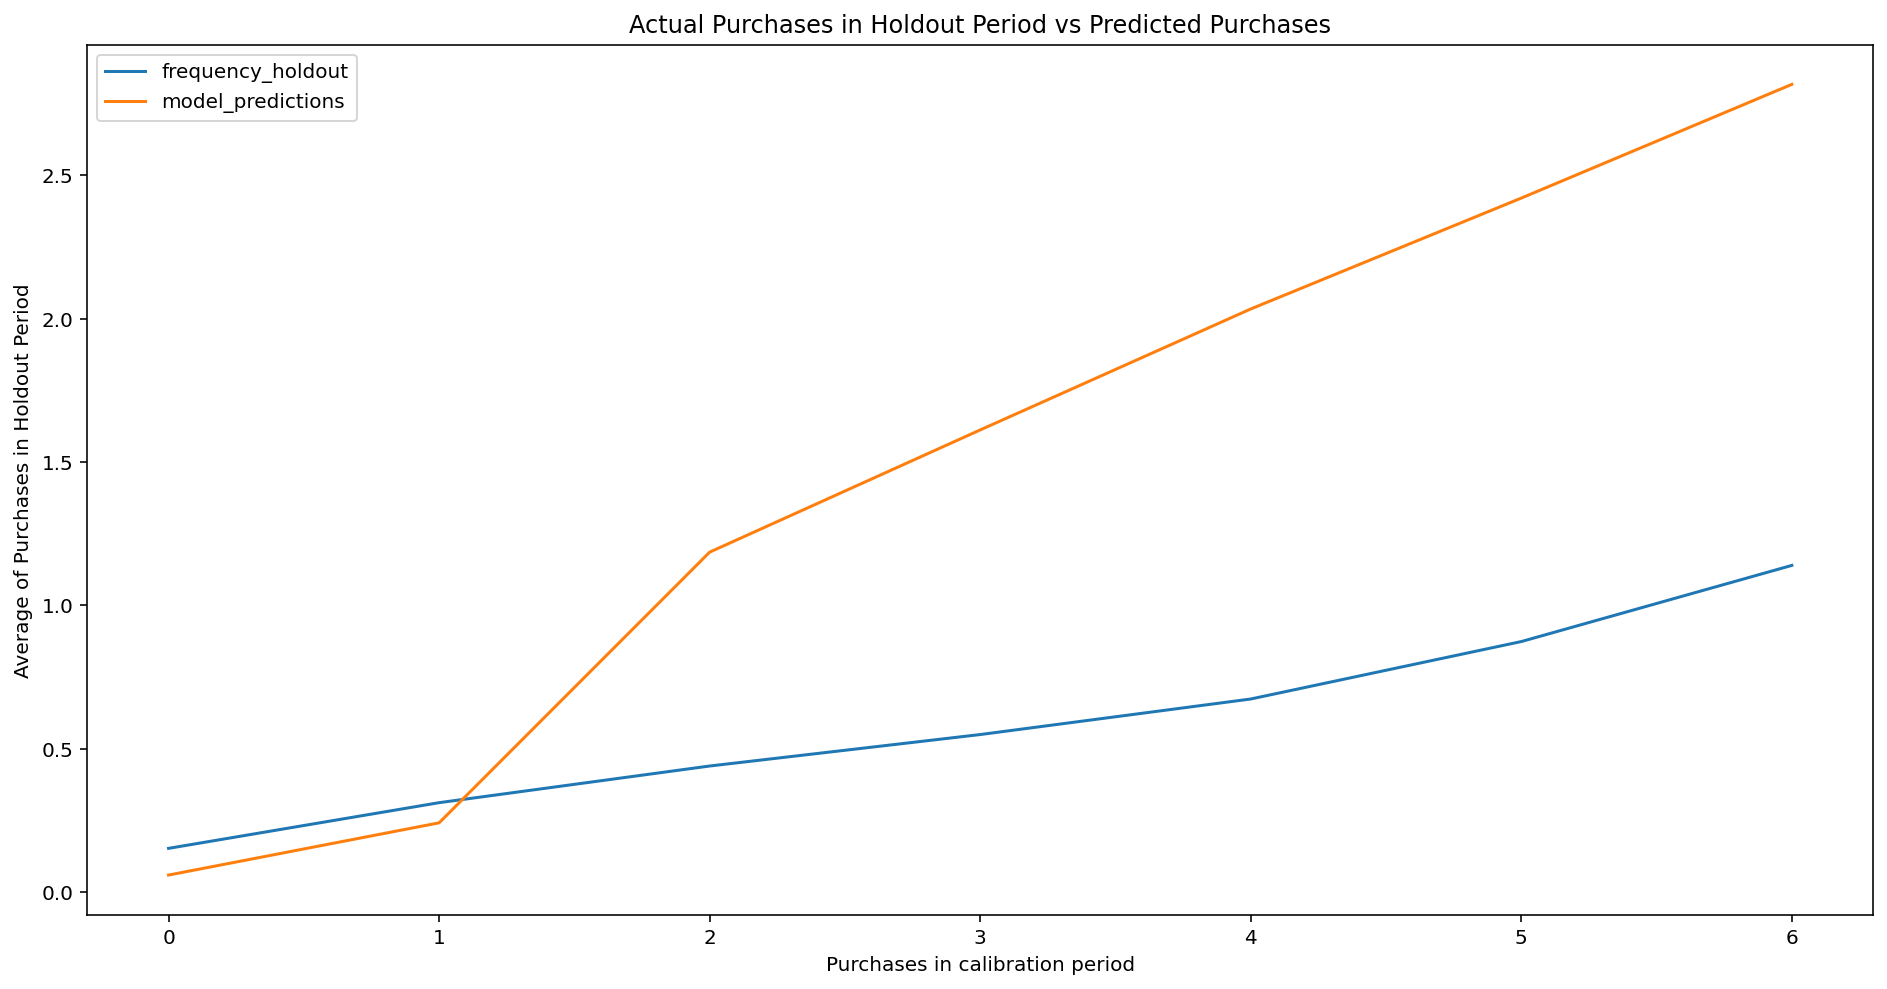

In [41]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Model summary
bgf.summary

       customer_id  number_of_purchases        receipt_date  monetary_value  \
461246  H47HL2NVZ1                   38 2018-09-01 02:16:04           12.61   
461246  H47HL2NVZ1                   38 2018-03-29 23:55:34            9.69   
461246  H47HL2NVZ1                   38 2018-04-28 06:12:15           11.80   
461246  H47HL2NVZ1                   38 2018-11-07 04:30:06           10.29   
461246  H47HL2NVZ1                   38 2019-11-12 09:09:56            5.90   
461246  H47HL2NVZ1                   38 2018-11-18 12:09:40           11.57   
461246  H47HL2NVZ1                   38 2018-09-21 14:26:31           12.23   
461246  H47HL2NVZ1                   38 2018-08-30 08:13:59            6.72   
461246  H47HL2NVZ1                   38 2019-01-24 11:57:19           10.31   
461246  H47HL2NVZ1                   38 2018-08-29 19:44:20           16.25   
461246  H47HL2NVZ1                   38 2018-05-14 06:15:19            3.78   
461246  H47HL2NVZ1                   38 2019-07-10 0

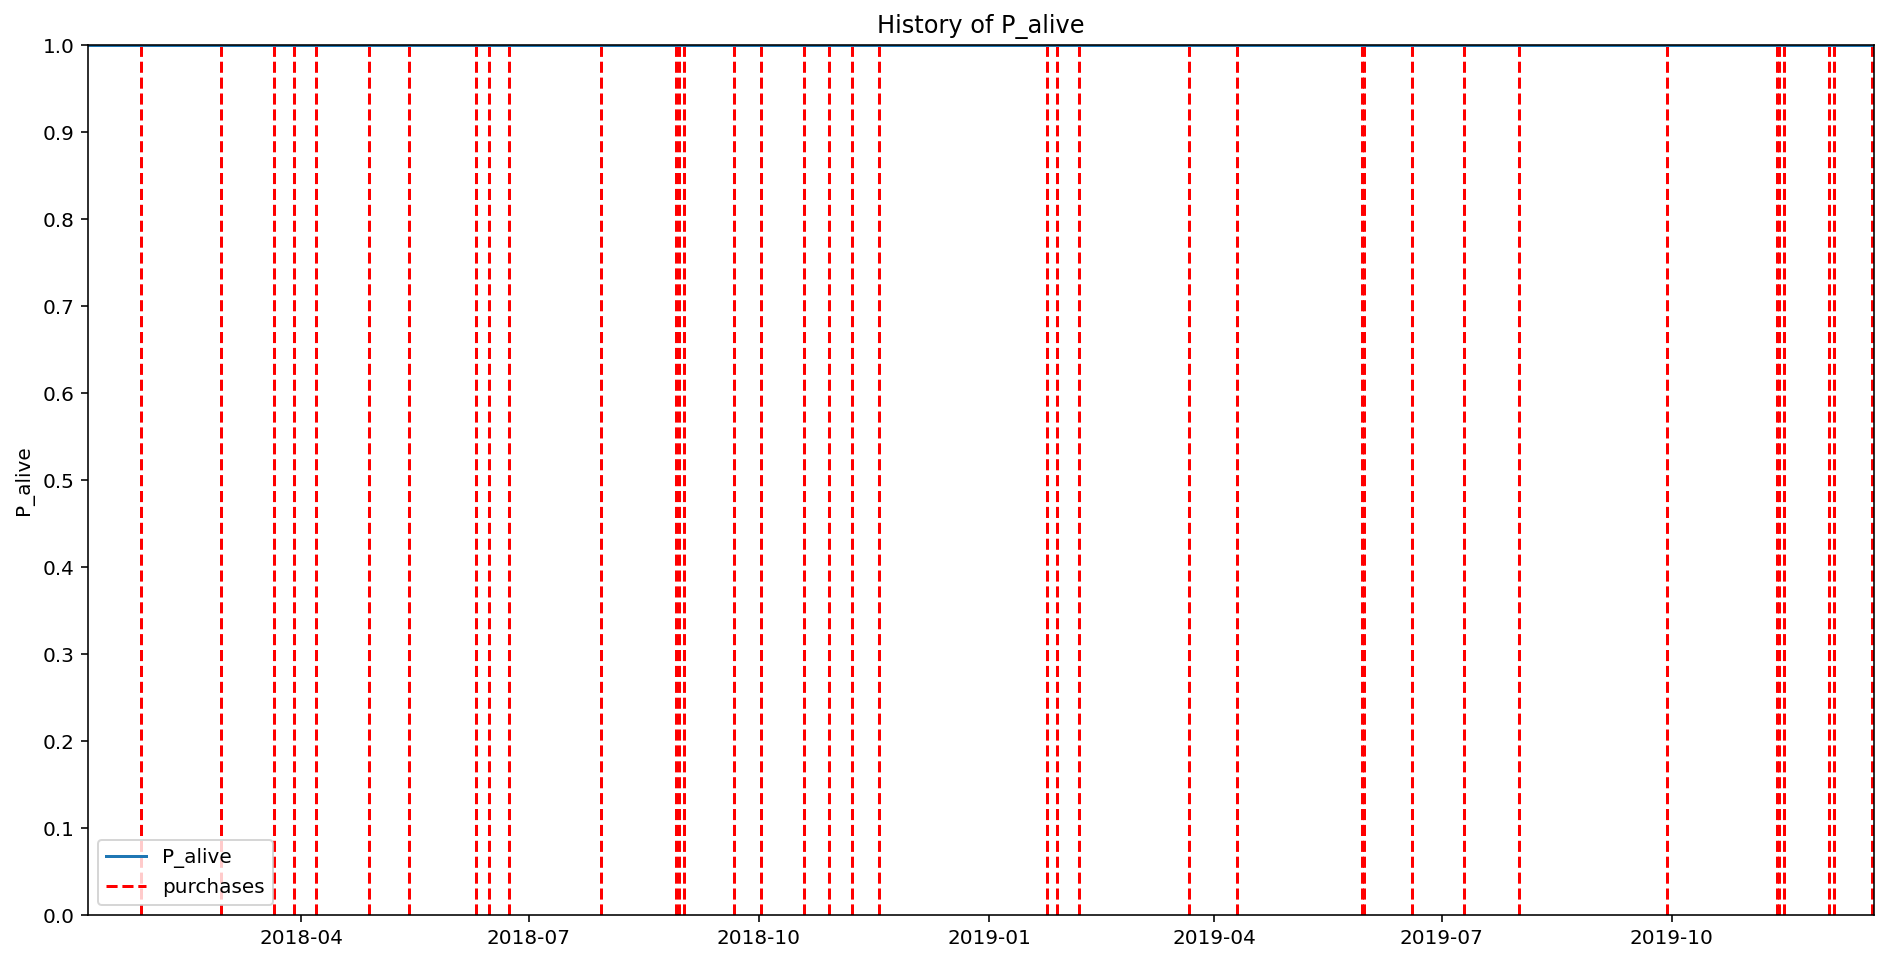

In [453]:
# We can visualize one particular customer
from lifetimes.plotting import plot_history_alive

id = df_ml.loc[df_ml.number_of_purchases > max_purchase_number/6].sample(1).iloc[0].customer_id

print(df_ml.loc[df_ml.customer_id == id])
days_since_birth = round((pd.to_timedelta(pd.Timestamp('2020-01-01T00') 
                  - pd.Timestamp((df_ml.loc[df_ml['customer_id'] == id]['receipt_date'].min()))).days) / 7)
plot_history_alive(bgf, 
                   days_since_birth, 
                   df_ml.loc[df_ml['customer_id'] == id], 
                   'receipt_date',
                   #xlim=['2017-11-01T00','2020-01-01T00']
                  )

In [454]:
# Transform transaction data into customer-based data with three attributes
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(df_ml, 
                                             'customer_id', 
                                             'receipt_date', 
                                             observation_period_end='2020-01-01',
                                             datetime_format = '%Y-%m-%d',
                                             freq='W',
                                             monetary_value_col = 'monetary_value')
summary.sample(2)

,frequency,recency,T,monetary_value
customer_id,,,,
0K0PXY11PB,0.0,0.0,74.0,0.00
L8W199LWS8,11.0,83.0,91.0,11.55


In [455]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.08e-01,1.90e-04,1.07e-01,1.08e-01
alpha,1.16e+00,5.37e-03,1.15e+00,1.17e+00
a,4.47e-18,1.95e-14,-3.83e-14,3.83e-14
b,1.87e-05,2.24e-04,-4.20e-04,4.57e-04


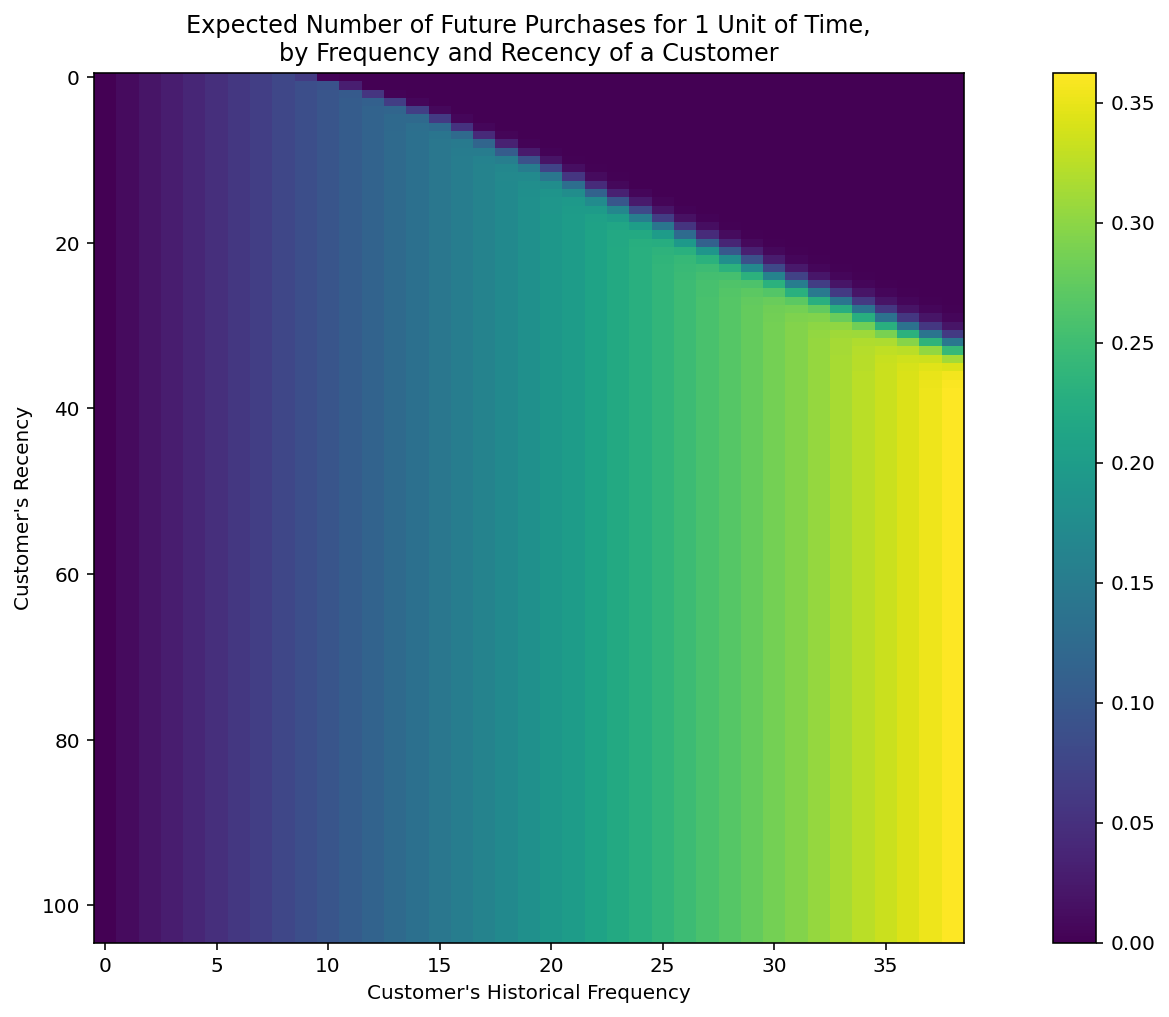

In [456]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

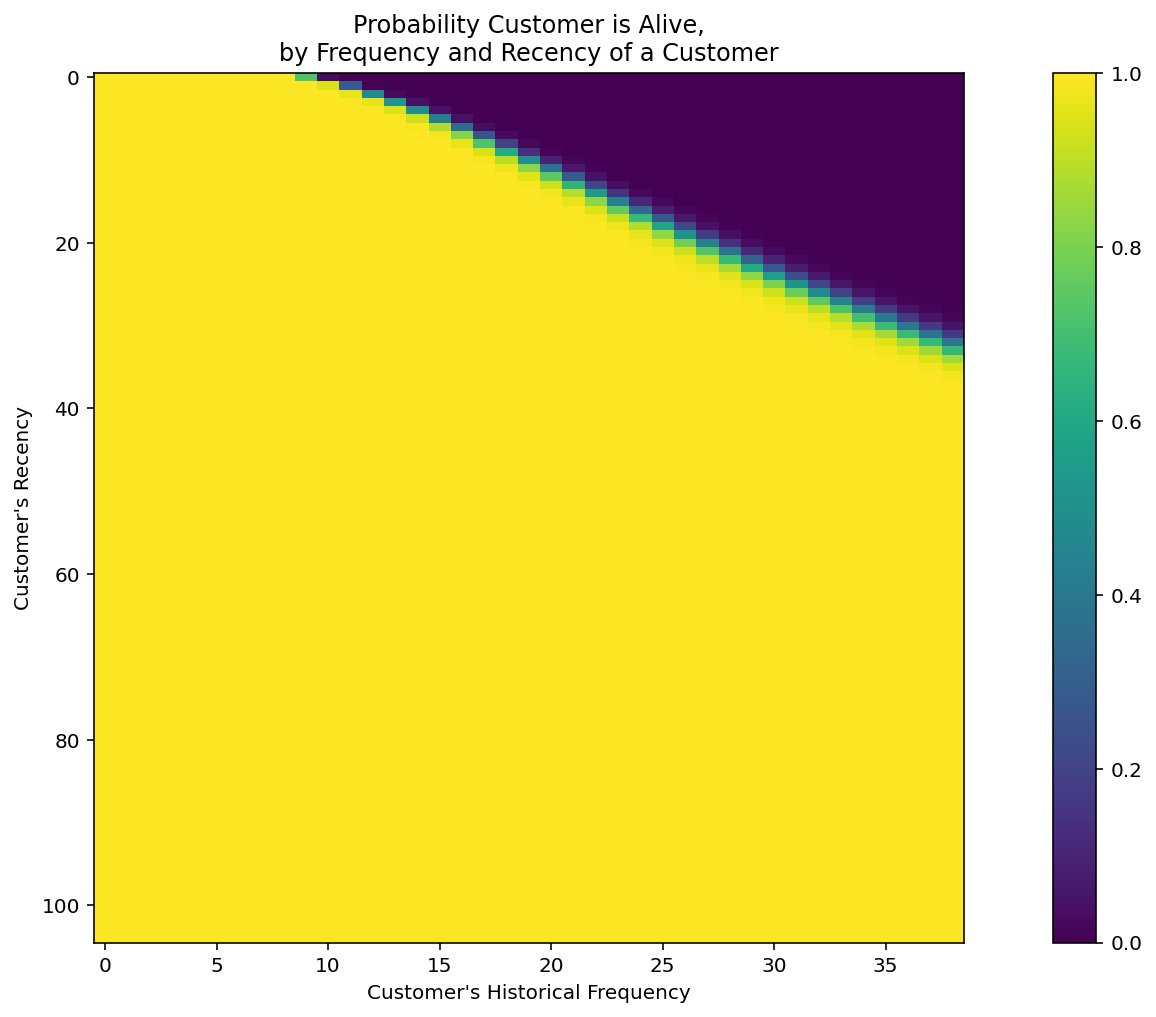

In [457]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

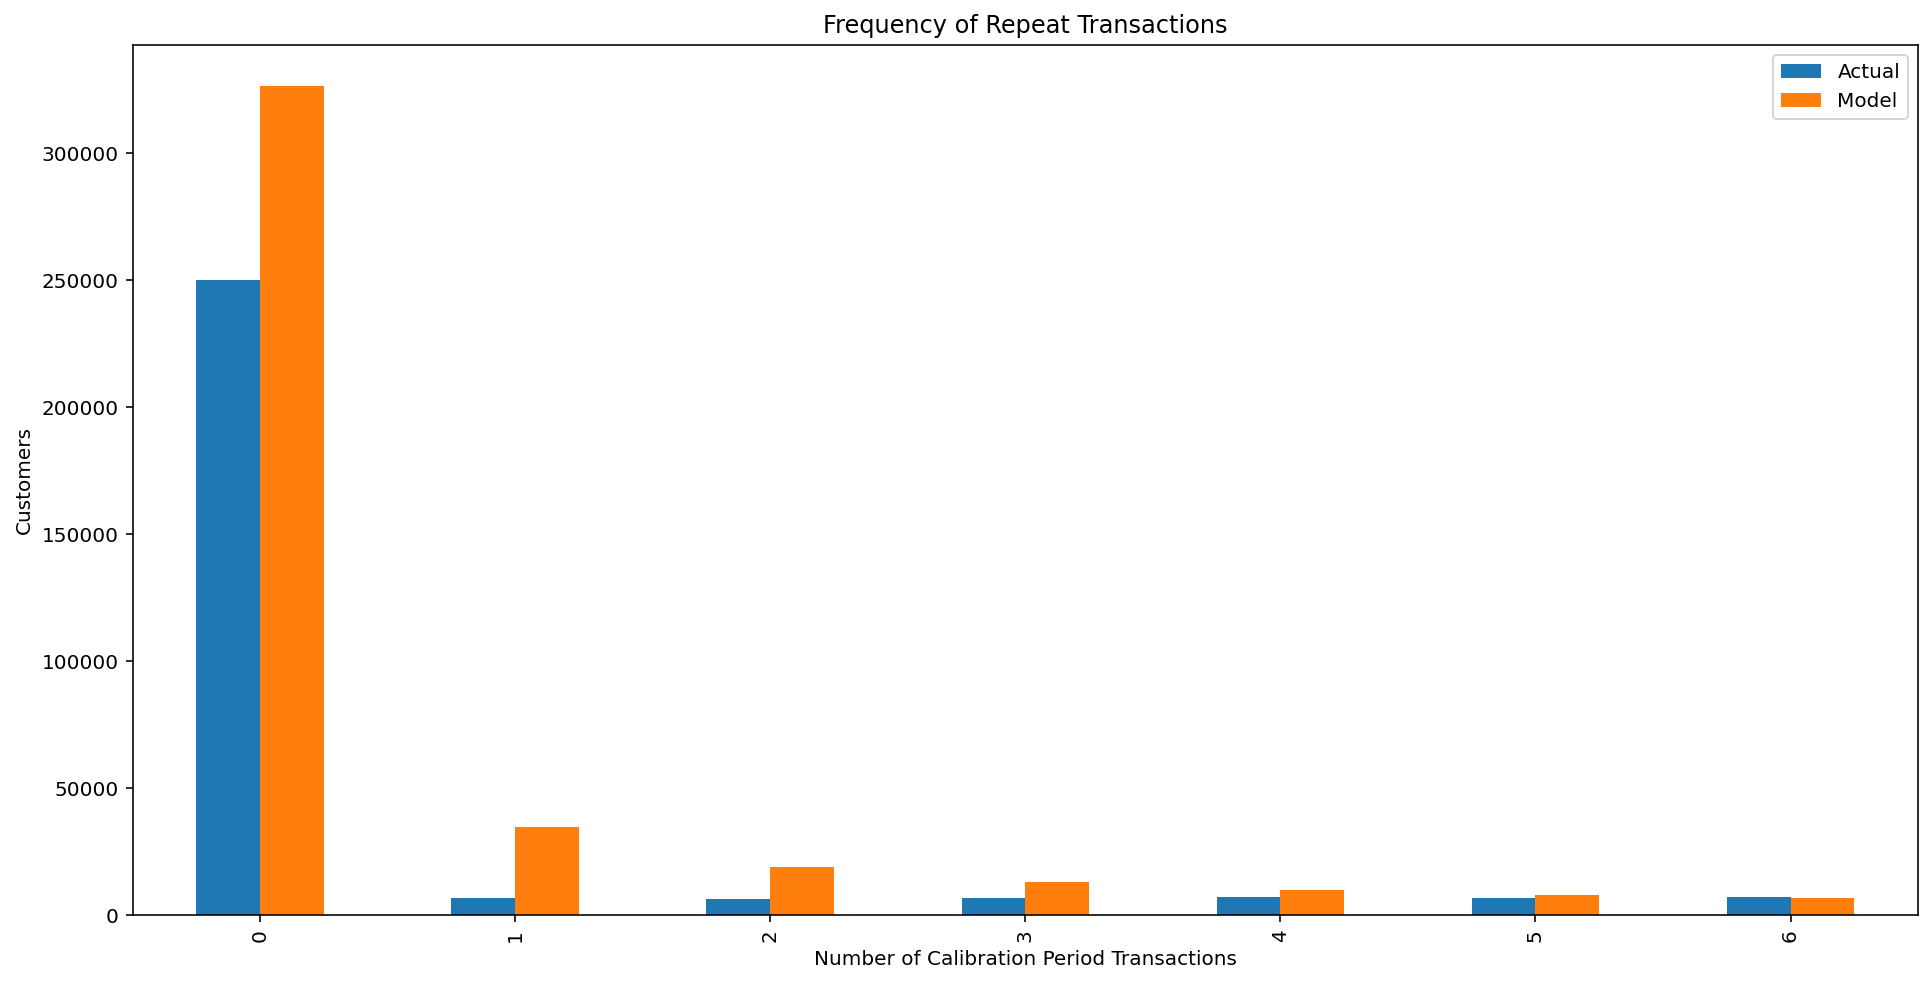

In [458]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [360]:
# Add predicted purchases to summary dataframe
# Predicted purchases are calculated for a given time window t
t = 12
summary['pred_purch_coming_week=' + str(t)] = (bgf.conditional_expected_number_of_purchases_up_to_time
                                               (
                                                t, 
                                                summary['frequency'], 
                                                summary['recency'], 
                                                summary['T']
                                               )
                                              )

/home/julien/anaconda3/envs/data_blog/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


             frequency  recency      T  monetary_value  \
customer_id                                              
5TX56GVQ7C         0.0      0.0  104.0             0.0   
DRLCZ8JOYT         0.0      0.0  104.0             0.0   
94WYYHNS2J         0.0      0.0  104.0             0.0   
7S5APVDOQK         0.0      0.0  104.0             0.0   
C60QZMO4KW         0.0      0.0  104.0             0.0   

             pred_purch_coming_week=12  
customer_id                             
5TX56GVQ7C                        0.01  
DRLCZ8JOYT                        0.01  
94WYYHNS2J                        0.01  
7S5APVDOQK                        0.01  
C60QZMO4KW                        0.01  

[5 rows x 5 columns]


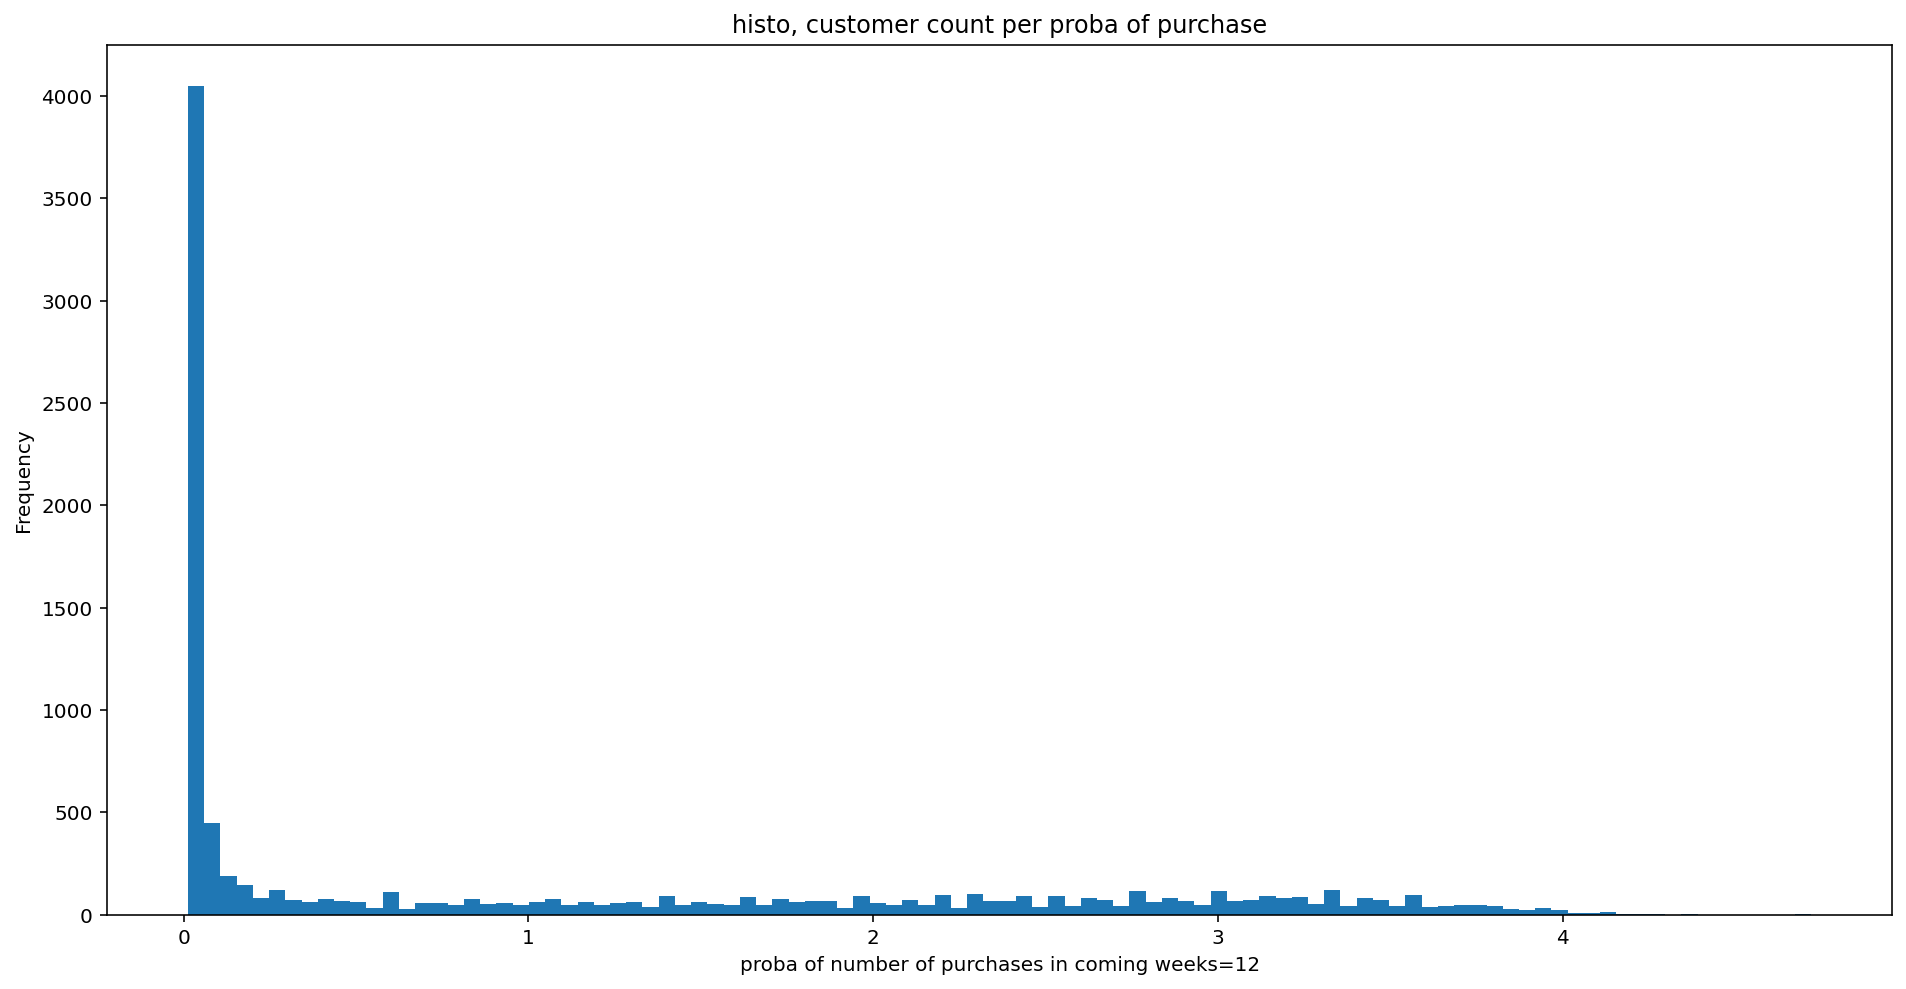

In [361]:
print(summary.sort_values(by='pred_purch_coming_week=' + str(t)).head(5))
summary['pred_purch_coming_week=' + str(t)].plot(kind='hist',bins=100)
plt.xlabel('proba of number of purchases in coming weeks=' +str(t))
plt.title('histo, customer count per proba of purchase');

### I need to scale the data because my attributes have uncomparable scales

In [58]:
from sklearn.preprocessing import StandardScaler
to_cluster = summary[['pred_purch_coming_week=' + str(t),'monetary_value']]

# stscaler = StandardScaler().fit(to_cluster)
# to_cluster = stscaler.transform(to_cluster)
to_cluster = to_cluster.dropna()
to_cluster

,pred_purch_coming_week=12,monetary_value
club_card_number,,
1000044688,0.07,0.0
1000051773,0.09,0.0
1000076175,0.08,0.0
1000081821,0.07,0.0
1000088953,0.08,0.0
...,...,...
9500856806,0.17,0.0
9500867467,0.22,0.0
9500889732,0.20,0.0


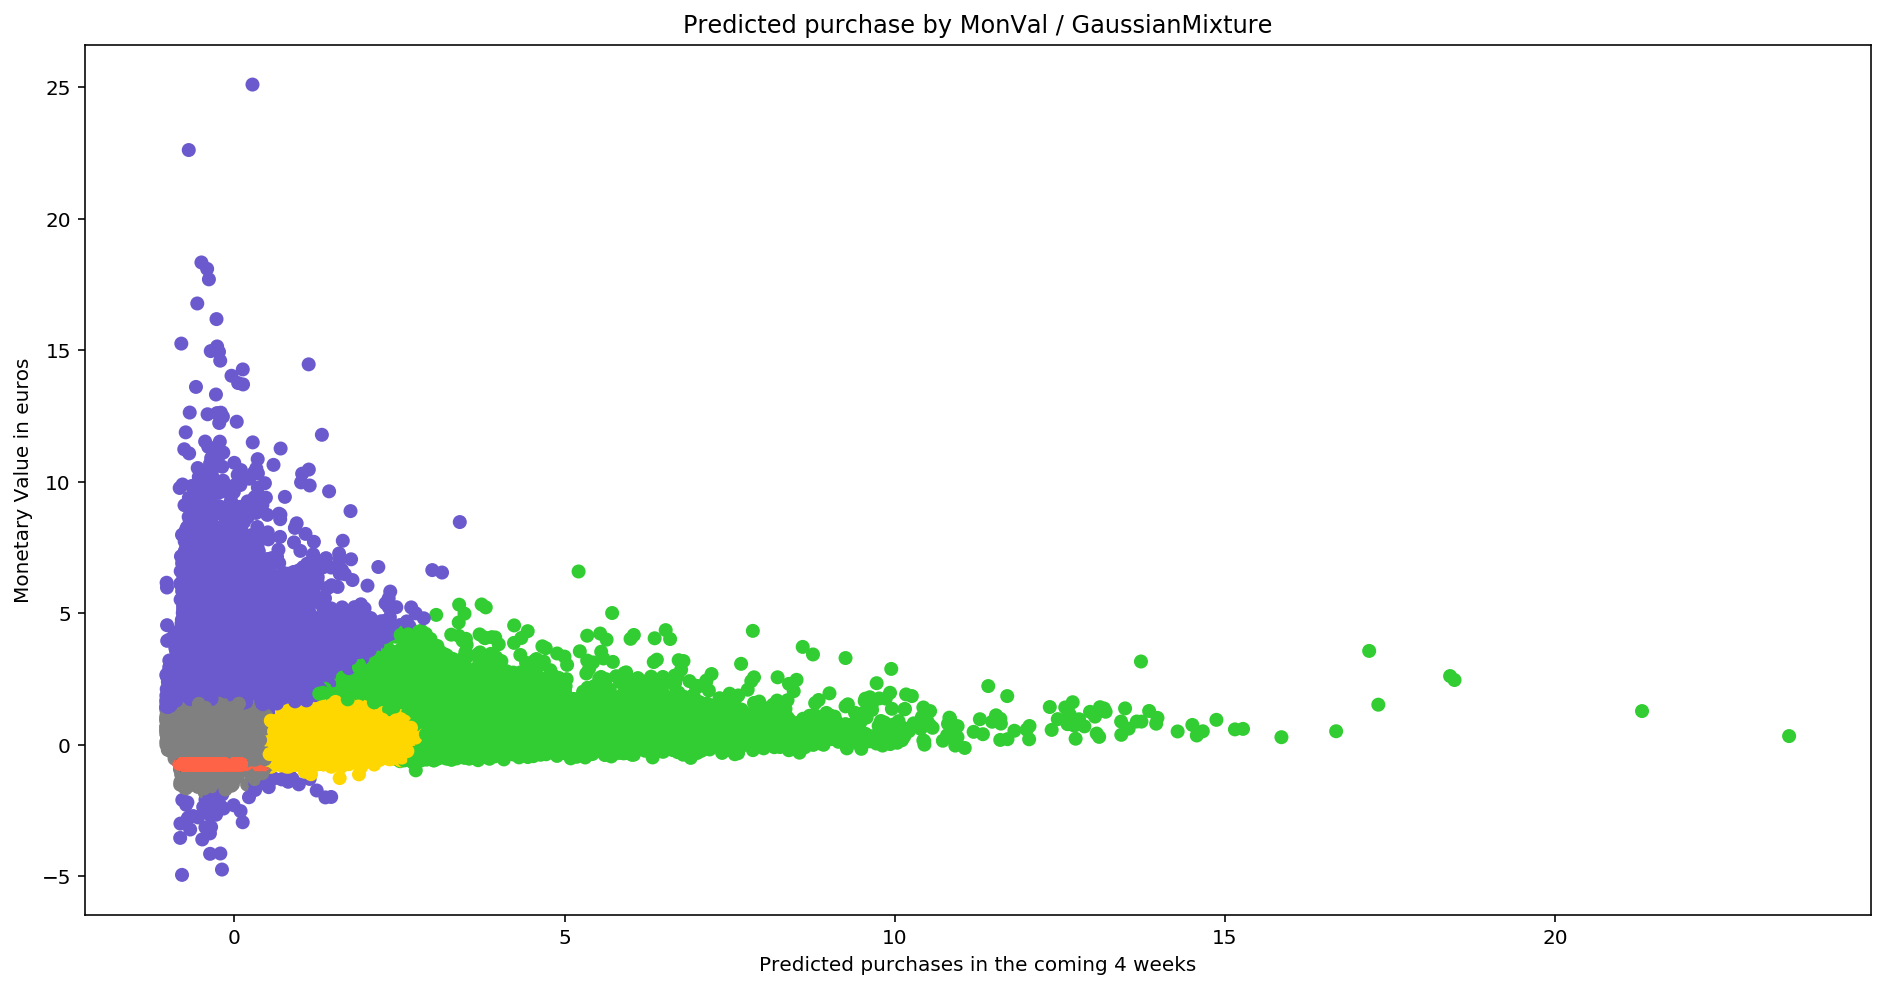

In [76]:
from sklearn.mixture import GaussianMixture

from sklearn import cluster, mixture
from sklearn.cluster import KMeans

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 5,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
params = default_base.copy()

# ============
# Create cluster objects
# ============

#ms = cluster.MeanShift(bin_seeding=True)
#two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
#affinity_propagation = cluster.AffinityPropagation(
#    damping=params['damping'], preference=params['preference'])
#birch = cluster.Birch(n_clusters=params['n_clusters'])
#dbscan = cluster.DBSCAN(eps=params['eps'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')
km = KMeans(n_clusters=params['n_clusters'], 
             max_iter=100, 
             init='k-means++', 
             n_init=1,
             random_state=42,
             verbose=0)

clustering_algorithms = (
   #('MiniBatchKMeans', two_means),
     #('AffinityPropagation', affinity_propagation),
    #('MeanShift', ms),
    #('Birch', birch),
    #('DBSCAN', dbscan),
    ('GaussianMixture', gmm))

#for name, algorithm in clustering_algorithms:
gmm.fit(to_cluster)
y_pred = gmm.predict(to_cluster)
label_colors = ["tomato", "grey", "limegreen", "gold", "slateblue", "moccasin"]
colors = [label_colors[i] for i in y_pred]
plt.scatter(to_cluster[:, 0], to_cluster[:, 1], color=colors)
plt.xlabel('Predicted purchases in the coming 4 weeks')
plt.ylabel('Monetary Value in euros')
plt.title('Predicted purchase by MonVal / ' + str(clustering_algorithms[0]));
plt.savefig('cluster_all.png')

In [91]:
unique, counts = np.unique(y_pred, return_counts=True)
label_colors = ["tomato", "grey", "limegreen", "gold", "slateblue"]
print(counts)
print()
unique, counts = np.unique(y_pred, return_counts=True)
print(pd.concat([pd.DataFrame(label_colors), pd.DataFrame(counts)], axis = 1))

[ 34413 239637  47325   5487 157760]

           0       0
0     tomato   34413
1       grey  239637
2  limegreen   47325
3       gold    5487
4  slateblue  157760


In [98]:
counts.sum()

484622

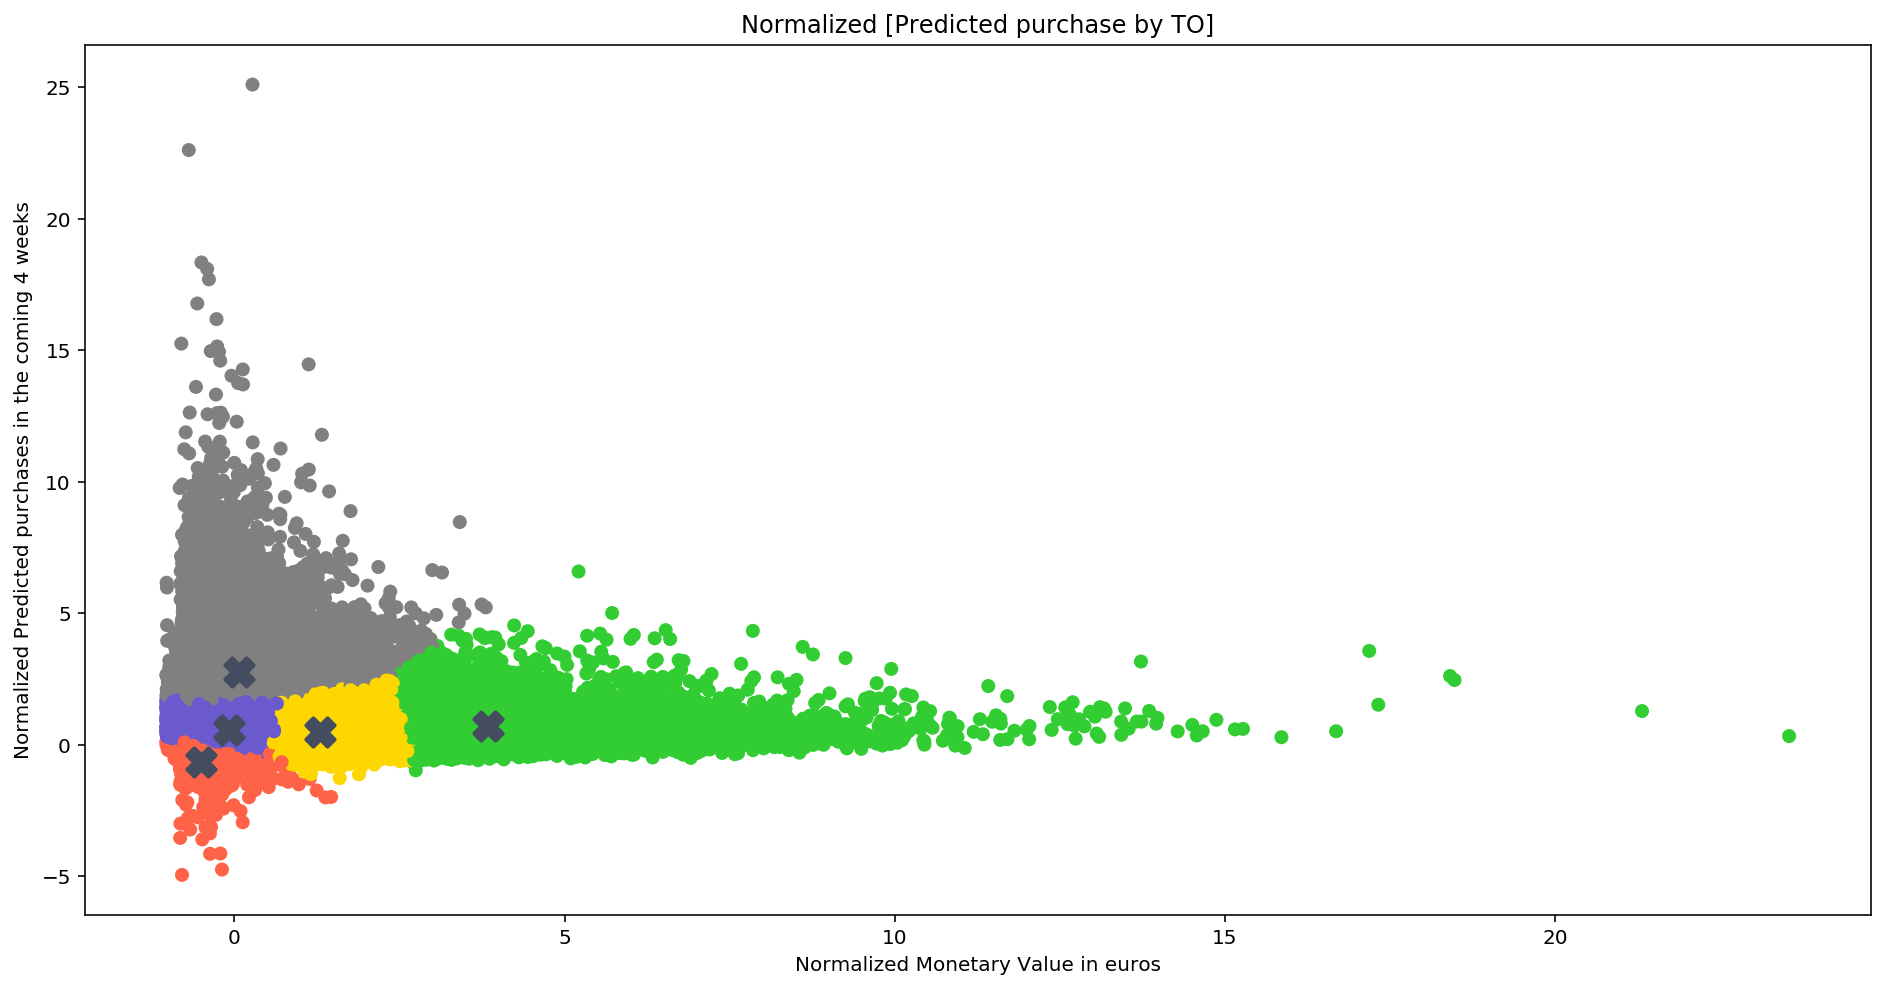

In [77]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture
from sklearn.cluster import KMeans

to_cluster = summary[['pred_purch_coming_week=' + str(t),'monetary_value']]
to_cluster = to_cluster.dropna()

stscaler = StandardScaler().fit(to_cluster)
to_cluster = stscaler.transform(to_cluster)

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 5,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
params = default_base.copy()
# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
birch = cluster.Birch(n_clusters=params['n_clusters'])
dbscan = cluster.DBSCAN(eps=params['eps'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')
vbgmm= mixture.BayesianGaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')
km = KMeans(n_clusters=params['n_clusters'], 
             max_iter=100, 
             init='k-means++', 
             n_init=1,
             # Random state is where does the centroids start. 
             # I defined this after looking at different results
             # IMPORTANT is to verify validity of this approach from a conceptual perspective
             random_state=42,
             verbose=0)

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('Birch', birch),
    ('DBSCAN', dbscan),
    ('GaussianMixture', gmm))

#for name, algorithm in clustering_algorithms:
km.fit(to_cluster)
y_pred = km.predict(to_cluster)
label_colors = ["tomato", "grey", "limegreen", "gold", "slateblue", "moccasin", "grey"]
colors = [label_colors[i] for i in y_pred]
plt.scatter(to_cluster[:, 0], 
            to_cluster[:, 1], 
            color=colors)
plt.xlabel('Normalized Monetary Value in euros')
plt.ylabel('Normalized Predicted purchases in the coming 4 weeks')
plt.title('Normalized [Predicted purchase by TO]');


centroids = km.cluster_centers_
#centroid_coords = pca.transform(centroids)
plt.scatter(centroids[:, 0], 
            centroids[:, 1], 
            marker='X', 
            s=200, 
            linewidths=2, 
            c='#444d60');

plt.savefig('cluster_all.png')

In [82]:
label_colors = ["tomato", "grey", "limegreen", "gold", "slateblue"]
unique, counts = np.unique(y_pred, return_counts=True)
print(counts)
print()



cluster_count = pd.concat([pd.DataFrame(label_colors), pd.DataFrame(counts)], axis = 1)#.sort_values(by='')
print(cluster_count)

[270826  26996  14562  67091 113228]

           0       0
0     tomato  270826
1       grey   26996
2  limegreen   14562
3       gold   67091
4  slateblue  113228

[5 rows x 2 columns]


In [86]:
[(i/np.sum(counts))*100 for i in counts]

[25.1664183631779,
 5.590955425052928,
 59.25793711387431,
 8.886719959060876,
 1.0979691388339778]

In [28]:
unique, counts = np.unique(km.labels_, return_counts=True)
counts

array([121962,  27095, 287177,  43067,   5321], dtype=int64)

In [90]:
# Based on customer history, we can predict what an individuals future purchases might look like:
t = 4 #predict purchases in t periods
individual = summary.iloc[12386]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.025169409509570598

## Including transactional component

### The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel

In [94]:
returning_customers_summary = summary[summary['frequency']>0]
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value']>0]

In [95]:
returning_customers_summary#[['monetary_value', 'frequency']].corr()

,frequency,recency,T,monetary_value,pred_purch_coming_week=12
SFID,,,,,
0031i000001rNG6AAM,3.0,37.0,41.0,36.88,0.76
0031i000001rNGMAA2,1.0,13.0,68.0,8.02,0.13
0031i000001rNGRAA2,2.0,60.0,68.0,15.91,0.35
0031i000001rNGTAA2,2.0,36.0,68.0,52.46,0.30
0031i000001rNH5AAM,2.0,3.0,68.0,74.42,0.05
...,...,...,...,...,...
0035800001gxbOqAAI,12.0,65.0,68.0,30.62,1.86
0035800001gxbOuAAI,8.0,38.0,68.0,9.38,0.58
0035800001gxbWUAAY,10.0,64.0,68.0,13.82,1.55


In [96]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 117020 subjects, p: 1.86, q: 7.11, v: 92.53>


In [97]:
ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],
                                        returning_customers_summary['monetary_value'])

SFID
0031i000001rNG6AAM    32.35
0031i000001rNGMAA2    23.49
0031i000001rNGRAA2    23.55
0031i000001rNGTAA2    37.39
0031i000001rNH5AAM    45.71
                      ...  
0035800001gxbOqAAI    30.10
0035800001gxbOuAAI    14.86
0035800001gxbWUAAY    17.37
0035800001gxbWXAAY    29.82
0035800001gxbWkAAI    21.43
Length: 117020, dtype: float64

In [98]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value']
    ).mean(),
    returning_customers_summary[returning_customers_summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 28.213612100866484, Average profit: 27.720022250879882


In [99]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(returning_customers_summary['frequency'], 
        returning_customers_summary['recency'], 
        returning_customers_summary['T'],
        returning_customers_summary['monetary_value'])

<lifetimes.BetaGeoFitter: fitted with 117020 subjects, a: 0.21, alpha: 22.48, b: 1.32, r: 2.17>

In [100]:
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=12, # months
    discount_rate=0.01,# monthly discount rate ~ 12.7% annually
    freq = 'W')

In [104]:
clv

SFID
0031i000001rNG6AAM    108.28
0031i000001rNGMAA2      9.06
0031i000001rNGRAA2     43.58
0031i000001rNGTAA2     50.25
0031i000001rNH5AAM      5.08
                       ...  
0035800001gxbOqAAI    212.12
0035800001gxbOuAAI     30.48
0035800001gxbWUAAY    104.24
0035800001gxbWXAAY     73.40
0035800001gxbWkAAI     27.26
Name: clv, Length: 117020, dtype: float64

In [102]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

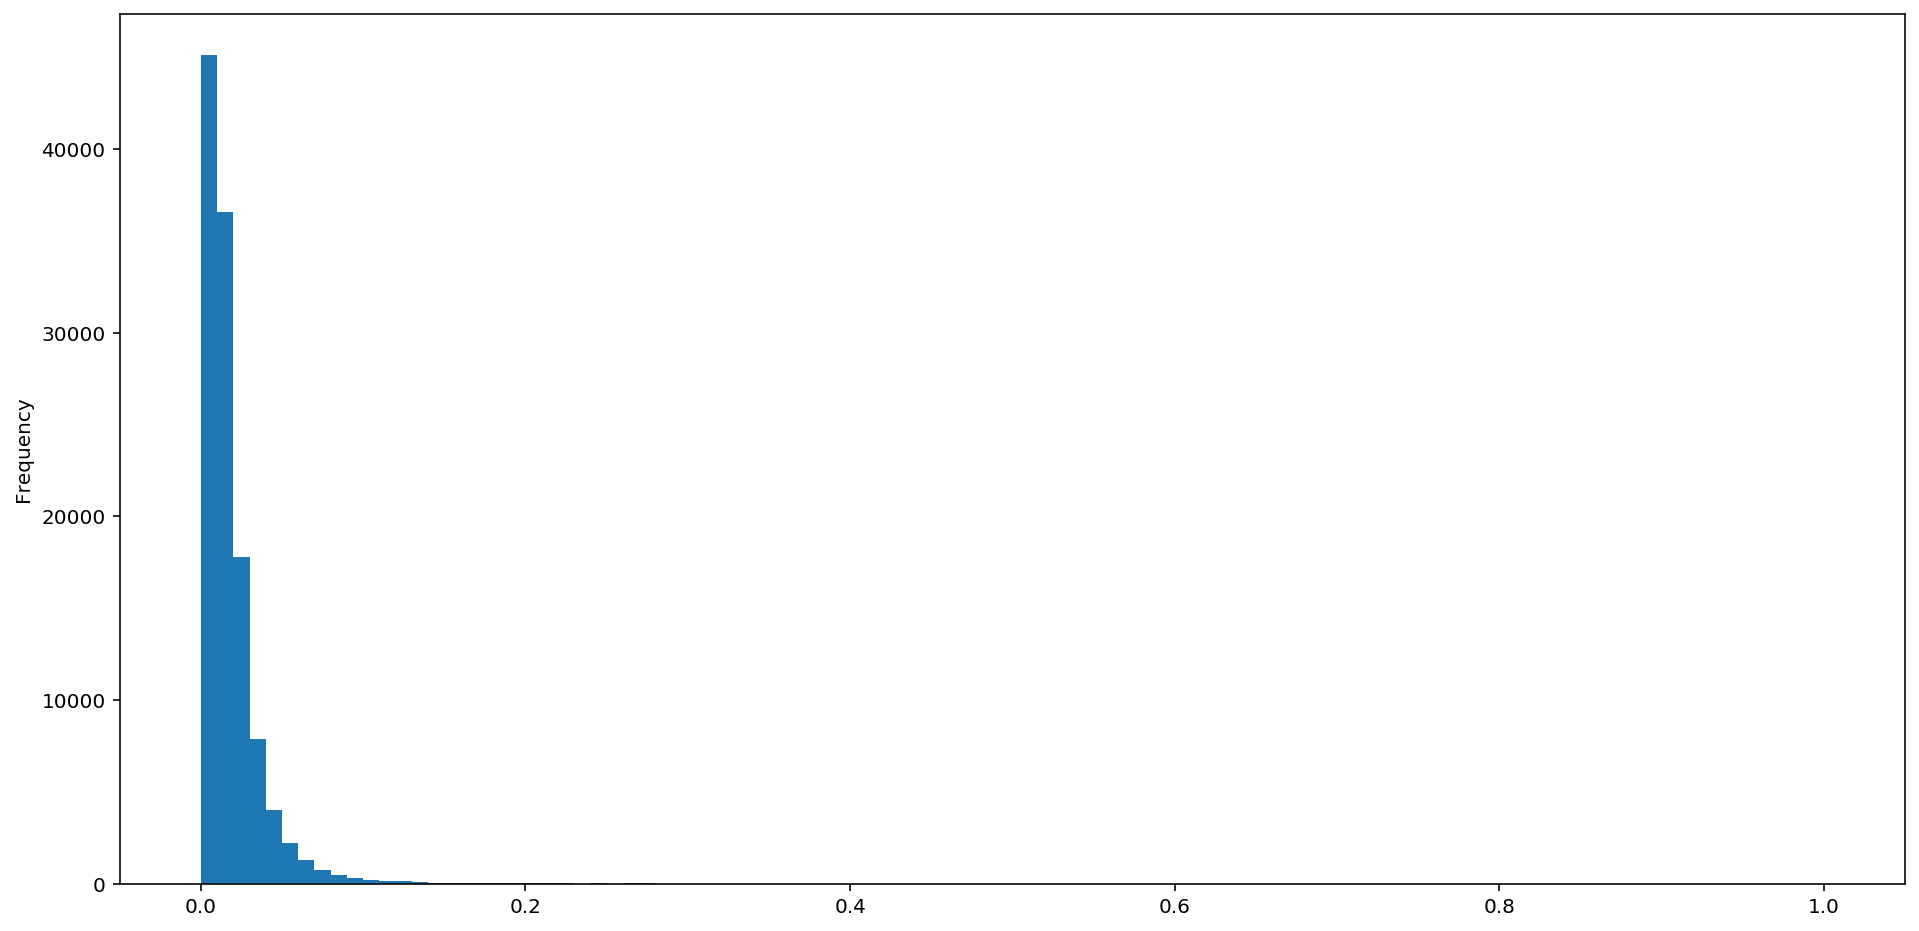

In [106]:
normalize(clv).plot(kind='hist', bins = 100)

## I am trying an RFM Segmentation, just for fun

In [115]:
quantiles = df_ml.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [310]:
segmented_rfm = df_ml.copy()

In [311]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [314]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles))
segmented_rfm.head()

,club_card_number,T,recency,frequency,monetary_value,predicted_purchases,r_quartile,f_quartile,m_quartile
0,2245598906,59.000000,0.142857,1,17.99,0.000183,1,4,4
1,7004667809,56.000000,0.142857,1,35.98,0.000207,1,4,3
2,8002162035,76.285714,0.142857,1,24.99,0.000099,1,4,4
3,9002067672,78.571429,0.142857,1,14.49,0.000092,1,4,4
4,9002488707,56.142857,0.142857,1,43.97,0.000206,1,4,2


0        144
1        143
2        144
3        144
4        142
        ... 
75121    442
75122    433
75123    441
75124    424
75125    431
Length: 75030, dtype: object

In [323]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str) 

segmented_rfm.head()

,club_card_number,T,recency,frequency,monetary_value,predicted_purchases,r_quartile,f_quartile,m_quartile,RFMScore
0,2245598906,59.000000,0.142857,1,17.99,0.000183,1,4,4,144
1,7004667809,56.000000,0.142857,1,35.98,0.000207,1,4,3,143
2,8002162035,76.285714,0.142857,1,24.99,0.000099,1,4,4,144
3,9002067672,78.571429,0.142857,1,14.49,0.000092,1,4,4,144
4,9002488707,56.142857,0.142857,1,43.97,0.000206,1,4,2,142


In [324]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,club_card_number,T,recency,frequency,monetary_value,predicted_purchases,r_quartile,f_quartile,m_quartile,RFMScore
8676,2246637250,20.285714,3.285714,5,225.104000,3.022869e-04,1,1,1,111
3161,2245355339,75.857143,1.285714,4,208.227500,6.699403e-08,1,1,1,111
4895,2246478594,14.428571,1.714286,4,179.925000,8.070156e-04,1,1,1,111
2129,2244817740,78.857143,0.857143,4,178.532500,2.337558e-08,1,1,1,111
9093,2245836304,37.000000,3.571429,9,171.054444,7.376102e-09,1,1,1,111
12861,2135671010,66.857143,5.571429,8,157.046250,3.913895e-09,1,1,1,111
18726,2245705487,39.571429,8.000000,4,152.577500,7.331495e-04,1,1,1,111
10604,2245627625,56.285714,4.428571,4,150.830000,1.268408e-05,1,1,1,111
2014,2246807797,11.428571,0.714286,5,150.186000,8.828257e-05,1,1,1,111
15029,2245253836,68.857143,6.571429,6,149.100000,4.584027e-07,1,1,1,111


# Comparing DeFacto & Orsay WM scoring

In [66]:
df_defacto

,SFID,ScoringIdentifier,Score
0,0031i00000J5bZkAAJ,Spring Special 2020,0.19
1,0031i00000Hhdq9AAB,Spring Special 2020,0.03
2,0031i00000J4DZWAA3,Spring Special 2020,0.05
3,0031i00000Pb315AAB,Spring Special 2020,0.08
4,0031i00000PZjouAAD,Spring Special 2020,0.06
...,...,...,...
8880164,0035800000ydPdBAAU,Spring Special 2020,0.69
8880165,0035800000zHNDIAA4,Spring Special 2020,0.02
8880166,0031i00000PZY9dAAH,Spring Special 2020,0.11
8880167,0031i00000LJtiXAAT,Spring Special 2020,0.37


In [81]:
df_orsay = summary.copy()
df_orsay.head(1)

,frequency,recency,T,monetary_value,pred_purch_coming_week=12
SFID,,,,,
0031i000001rNG6AAM,3.0,37.0,41.0,36.88,0.76


In [83]:
df_orsay.reset_index(level=0, inplace=True)
df_orsay.head(1)

,index,SFID,frequency,recency,T,monetary_value,pred_purch_coming_week=12
0,0,0031i000001rNG6AAM,3.0,37.0,41.0,36.88,0.76


In [ ]:
merged_data = df_orsay.merge(df_defacto, on='SFID', how='inner')

In [93]:
df_orsay.shape

(194134, 7)

In [92]:
merged_data.shape

(178003, 9)

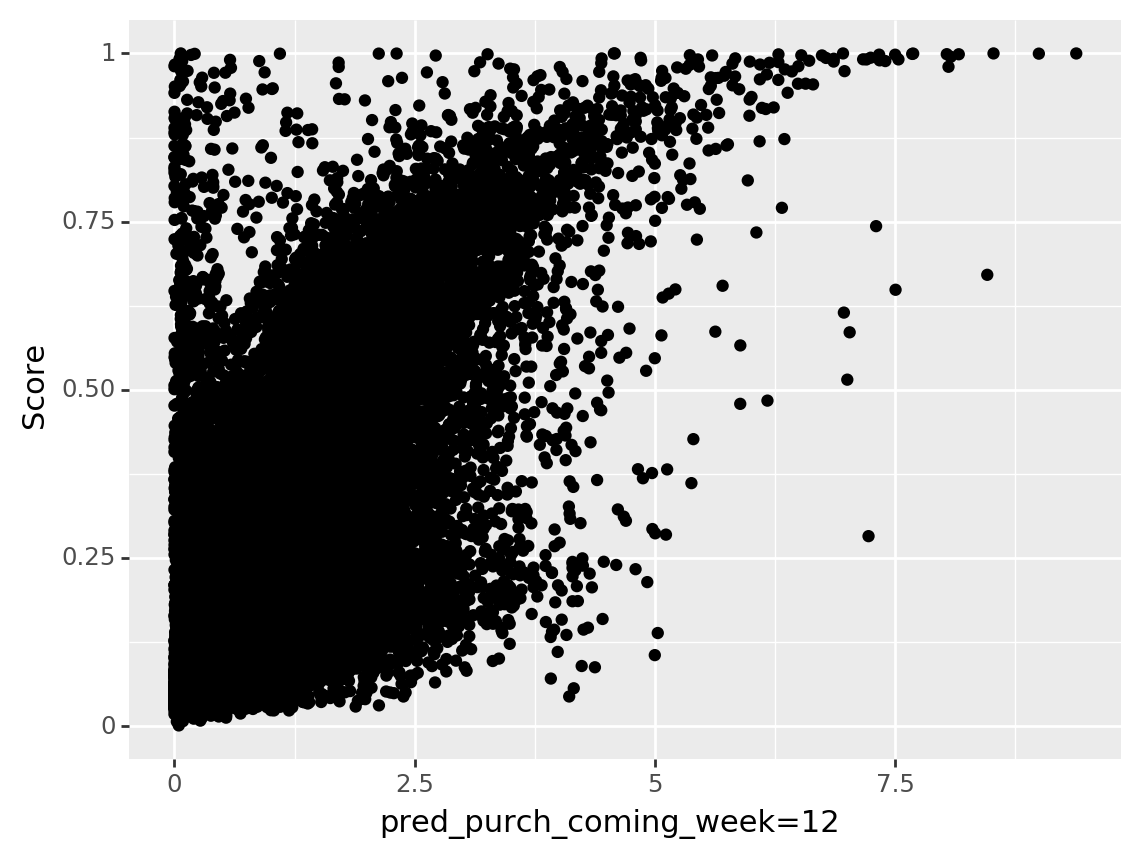

<ggplot: (-9223371895772317568)>

In [91]:
(p9.ggplot(mapping=p9.aes(x='pred_purch_coming_week=12', y='Score'), data=merged_data)
+ p9.geom_point())